# Introduction

This notebook demonstrates the use of the DeForMal package for Demand Load Forecasting.

# Step 1: Import libraries and set country, period and some constants

In [1]:
import netCDF4

In [1]:
import prepdata
import evaluate as ev
import forecast_models as fm
from forecast_models import NN_Model
import os
import pandas as pd
import numpy as np
import pprint as pp

%matplotlib widget





loginfile    = '../userdata/Jethro_login.txt' #'../userdata/login.txt'

country_code = 'LU'
country_dir = '../data/Luxembourg/'

startdate    = '2020-01-01'
enddate      = '2023-12-31'


# Step 2: Get the actual demand load data and the TSO forecast and inspect it

The actual demand data will be used to train our own model, and as a reference for validation, so it is necessary to inspect it for any errors or artefacts. The forecast by the Transmission System Operator (TSO) will be used to measure our own forecast against, so          


For this step to work you need to register at https://transparency.entsoe.eu/ and save the access key in '../userdata/logins.txt'

The data for Luxembourg is already part of the package so you can skip the following code block if you are only interested in this case.

In [14]:
if not os.path.exists(country_dir) :
    os.mkdir(country_dir)  


filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

        # first get the power data from the ENTSO-E platform    
entsoe_obj = prepdata.EntsoePower( country_code, startdate, enddate, 
                              loginfile=loginfile )    
entsoe_filename = f'{filenamebase}_ENTSOE_power.pkl'    
entsoe_obj.pull_process_save(entsoe_filename)



### Inspect the data:

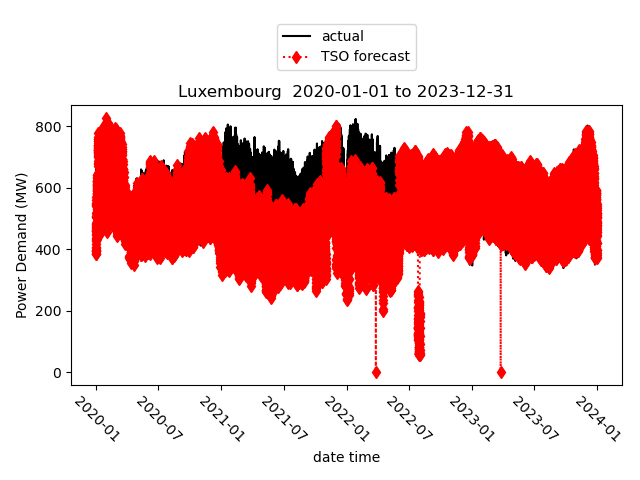

In [2]:


filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

actual_demand_df     = pd.read_pickle(f'{filenamebase}_ENTSOE_power_actual.pkl')
forecasted_demand_df = pd.read_pickle(f'{filenamebase}_ENTSOE_power_forecast.pkl')

# init an evaluation object with the data
ev_object = ev.Eval(actual_demand_df,forecasted_demand_df , unit='MW',
                           model_name= 'TSO forecast', location= 'Luxembourg')

ev_object.timeseries_plot()




### Selection of validation period

When we hoover our mouse pointer over the figure above, a widget menu will appear on the top left of the figure. Clicking on the cross symbol and using our left and right mouse buttons, we can scroll and zoom through the figure. We can  see that during large periods the forecast provided by the Transmission System Operator (TSO) works fairly well, but there are also periods where there is a large negative bias, and that 2022-02-22 is missing completely. The abrupt appearance and dissapearance of these biases suggest these are artefacts, rather than inherent flaws of the underlying forecast model(s). They could be caused by subgrid operators or large industrial clients not provided their forecast in time, or technical problems with the data transfer. Additionaly there are artefacts in the spring of 2022 and 2022 due to the daylight savings time shift. Strangely enough this problem does not occur in 2020.

Taking a period where the TSO has substantial artefacts, would make it quite easy to be better with our own method, and would not give a realistic assesment of the quality of the neural network based model. Therefore  we choose 2023 as the validation period, and deselect the daylight saving time artefact.

### Validation of the TSO forecast

We can now evaluate the performance of the TSO forecast for this period:


                          value unit  \
total nr data pairs        8760    1   
nr of valid actual points  8759    1   
nr of valid model points   8759    1   
nr of valid data pairs     8758    1   

                                                                 description  
total nr data pairs                               total number of data pairs  
nr of valid actual points  Number of points of the actual (i.e. reference...  
nr of valid model points   Number of data points of the model in the inte...  
nr of valid data pairs       number of valid data pairs in the common period  
                    value unit  \
Mean Actual    536.209466   MW   
Stdv. Actual    98.586081   MW   
Mean Model     544.887912   MW   
Stdv. Model     97.846304   MW   
RMSE            19.089012   MW   
MBE              8.678446   MW   
BoSD            -0.739778   MW   
Disp            16.986102   MW   
MAE             14.344352   MW   
Pearson corr.    0.985045    1   
R2_score         0.962508    1

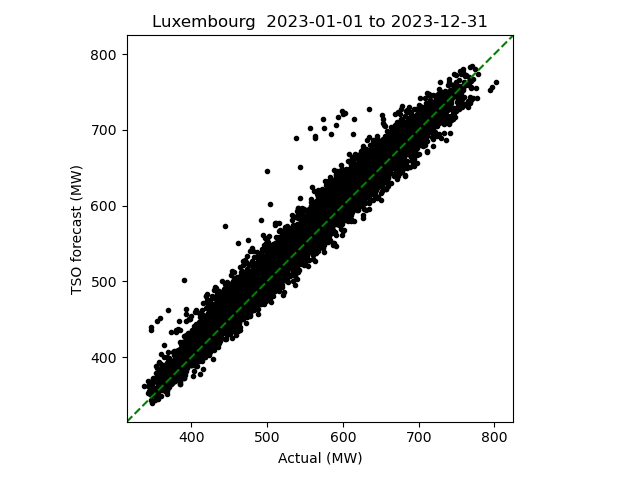

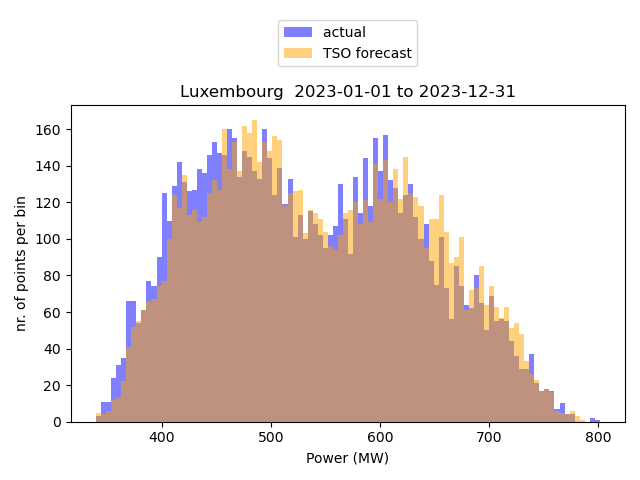

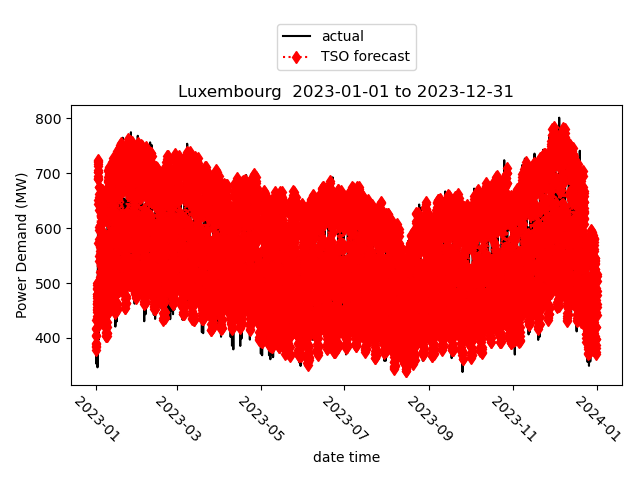

In [3]:
# Find the DST artefacts, and set the values to NaN

DST_artefact_index=forecasted_demand_df[forecasted_demand_df==0].index
actual_demand_df[DST_artefact_index]=np.nan

#seperate the validation period from the rest of the data
splitdate='2023-01-01'

actual_train, actual2eval=prepdata.split_df_on_date(splitdate, actual_demand_df )
forecast_train, forecast2eval=prepdata.split_df_on_date(splitdate, forecasted_demand_df )

ev_object= ev.Eval(actual2eval,forecast2eval, unit='MW', model_name='TSO forecast', location='Luxembourg')

print(ev_object.data_metrics)

ev_object.calc_acc_metrics()

print(ev_object.acc_metrics)

ev_object.scatter_plot()
ev_object.hist_compare_plot()
ev_object.timeseries_plot()



## Step 3: Get and prepare the data for the NN model

For this step to work you need to register at https://transparency.entsoe.eu/ and save the access key in '../userdata/logins.txt'

The data for Luxembourg is already part of the package so you can skip the following code block if you are only interested in this case.

The length of the training data should be short enough, such that long term trends are not missed, but long enough to train the network 

In [16]:
startdate    = '2020-01-01'
enddate      = '2023-12-31'

if not os.path.exists(country_dir) :
    os.mkdir(country_dir)  
        
prepdata.prep_all_data(country_code, startdate, enddate, 
            resultdir=country_dir, loginfile=loginfile )  

## Step 4: First simple NN model

We can now try our hand at the first simple NN model. We only use the time as a single variable

i:  0


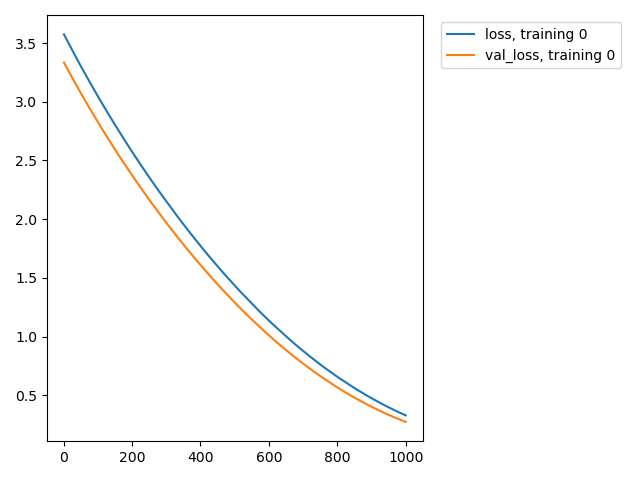

In [10]:

#load the data for the NN model

startdate    = '2020-01-01'
enddate      = '2023-12-31'

filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

actual_demand_df     = pd.read_pickle(f'{filenamebase}_ENTSOE_power_actual.pkl')
forecasted_demand_df = pd.read_pickle(f'{filenamebase}_ENTSOE_power_forecast.pkl')

actual_train, actual2eval=prepdata.split_df_on_date(splitdate, actual_demand_df )
forecast_train, forecast2eval=prepdata.split_df_on_date(splitdate, forecasted_demand_df )

#load the hour as single variable
hour_as_var_df = pd.read_pickle(f'{filenamebase}_hour_as_variable.pkl')
hour_as_var_train, hour_as_var_2eval  = prepdata.split_df_on_date(splitdate,hour_as_var_df )


#define the model 
firstmodel = NN_Model(hour_as_var_df.columns, hidden_nodes=12, hidden_layers=1 )

firstmodel.train_model(hour_as_var_train, actual_train, hour_as_var_2eval,actual2eval,
                   learning_rate=0.00001,verbose=0,epochs=1000, batch_size=100*24)

firstmodel.plot_history()




Let's look at the results:

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


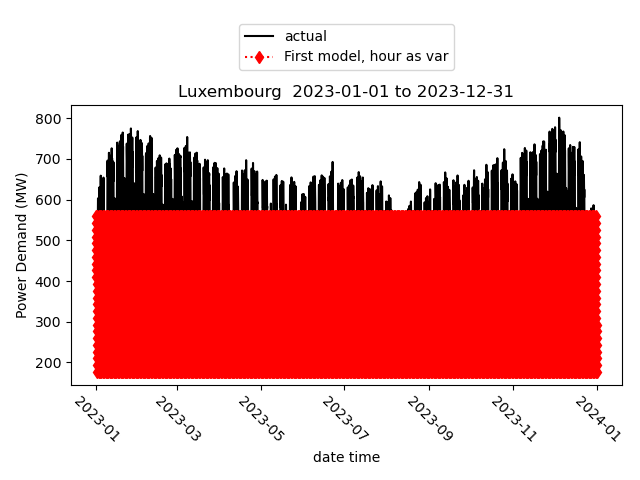

In [11]:
#apply the model to the validation period
P_model1=firstmodel.apply(hour_as_var_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model1, unit='MW', model_name='First model, hour as var', location='Luxembourg')
ev_object.timeseries_plot()

Since the input is only the hour of the day, the result will be the same for every day, 
Zooming into the figure we can see this is not working very well, the neural network approximates the curve as a straight line. Let's see if we can do better if we treat the hours as categories, i.e. each hour, minus one,  gets their own column in the input data and has a value of zero or one. 

In [12]:
#load the data and split
hour_as_cat_df = pd.read_pickle(f'{filenamebase}_hour_as_category.pkl')
hour_as_cat_train, hour_as_cat_2eval  = prepdata.split_df_on_date(splitdate,hour_as_cat_df )

#load the hour as single variable
hour_as_var_df = pd.read_pickle(f'{filenamebase}_hour_as_variable.pkl')
hour_as_var_train, hour_as_var_2eval  = prepdata.split_df_on_date(splitdate,hour_as_var_df )


i:  0
Epoch 1/1000
11/11 - 1s - 109ms/step - loss: 0.3592 - val_loss: 0.2927
Epoch 2/1000
11/11 - 0s - 7ms/step - loss: 0.3508 - val_loss: 0.2854
Epoch 3/1000
11/11 - 0s - 6ms/step - loss: 0.3425 - val_loss: 0.2782
Epoch 4/1000
11/11 - 0s - 7ms/step - loss: 0.3344 - val_loss: 0.2713
Epoch 5/1000
11/11 - 0s - 17ms/step - loss: 0.3265 - val_loss: 0.2645
Epoch 6/1000
11/11 - 0s - 7ms/step - loss: 0.3187 - val_loss: 0.2579
Epoch 7/1000
11/11 - 0s - 7ms/step - loss: 0.3112 - val_loss: 0.2515
Epoch 8/1000
11/11 - 0s - 6ms/step - loss: 0.3038 - val_loss: 0.2453
Epoch 9/1000
11/11 - 0s - 7ms/step - loss: 0.2966 - val_loss: 0.2392
Epoch 10/1000
11/11 - 0s - 8ms/step - loss: 0.2896 - val_loss: 0.2332
Epoch 11/1000
11/11 - 0s - 8ms/step - loss: 0.2827 - val_loss: 0.2275
Epoch 12/1000
11/11 - 0s - 21ms/step - loss: 0.2761 - val_loss: 0.2218
Epoch 13/1000
11/11 - 0s - 9ms/step - loss: 0.2695 - val_loss: 0.2163
Epoch 14/1000
11/11 - 0s - 7ms/step - loss: 0.2631 - val_loss: 0.2109
Epoch 15/1000
11/11

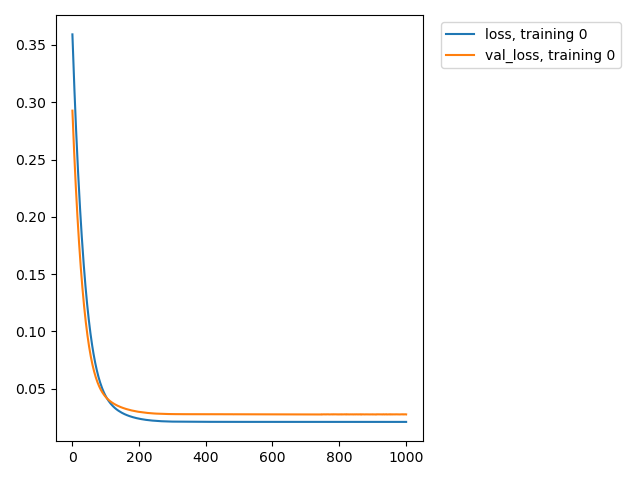

In [14]:

#define the model 
model2 = NN_Model(hour_as_cat_df.columns, hidden_nodes=12, hidden_layers=1 )

model2.train_model(hour_as_cat_train, actual_train, hour_as_cat_2eval,actual2eval,
                   learning_rate=0.0001,verbose=2,epochs=1000, batch_size=100*24)

model2.plot_history()



The interesting in the result above is that, despite the additional data,   the loss metric becomes stable much sooner than with less data

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


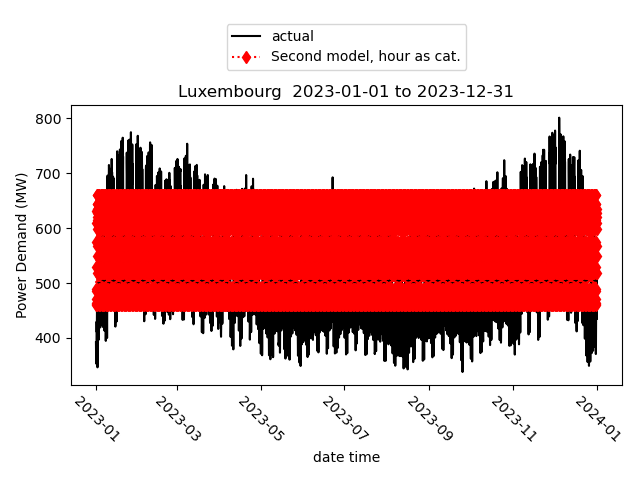

In [15]:
#apply the model to the validation period
P_model2=model2.apply(hour_as_cat_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model2, unit='MW', model_name='Second model, hour as cat.', location='Luxembourg')
ev_object.timeseries_plot()

# Step 5: Add calendar variables to the model

## load the data for the calendar variables, and combine them into one dataframe:

In [16]:
#daylight savingstime with a flag for the two days after the switch
DST_df = pd.read_pickle(f'{filenamebase}_daylight_savings_time_flags_lag_2.pkl')

#typedays, assuming that Tuesday till thursday behave the same
typedays_df = pd.read_pickle(f'{filenamebase}_combined_weekday_as_typeday.pkl')

#holidays, only differentiate between public, bank and school holidays
holiday_df = pd.read_pickle(f'{filenamebase}_holidays_by_type.pkl')

#bridgedays, treat the period between christmas and new year also as bridgedays:
bridgeday_df = pd.read_pickle(f'{filenamebase}_bridgedays_incl_yearend.pkl')

x_data = prepdata.combines_dfs(hour_as_cat_df, DST_df,typedays_df,holiday_df, bridgeday_df )

#split the x_data in training and evaluation data
x_data_train, x_data_2eval  = prepdata.split_df_on_date(splitdate,x_data )

Now we can define our new model, train it and validate it

i:  0


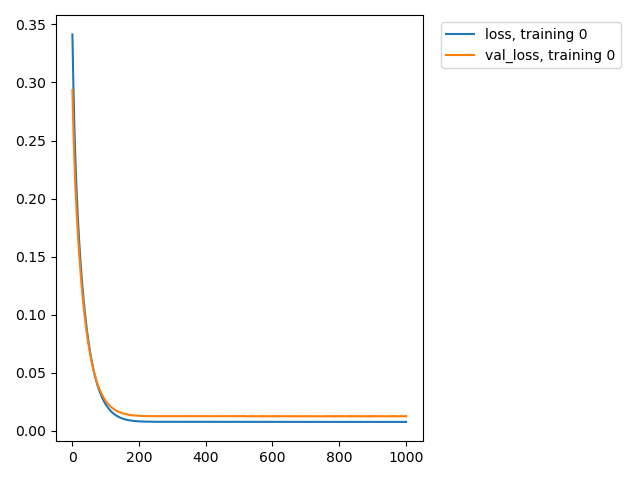

In [17]:
model3 = NN_Model(x_data.columns, hidden_nodes='mean_in_out', hidden_layers=1 )

model3.train_model(x_data_train, actual_train, x_data_2eval,actual2eval,
                   learning_rate=0.0001,verbose=0,epochs=1000, batch_size=100*24)

model3.plot_history()

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


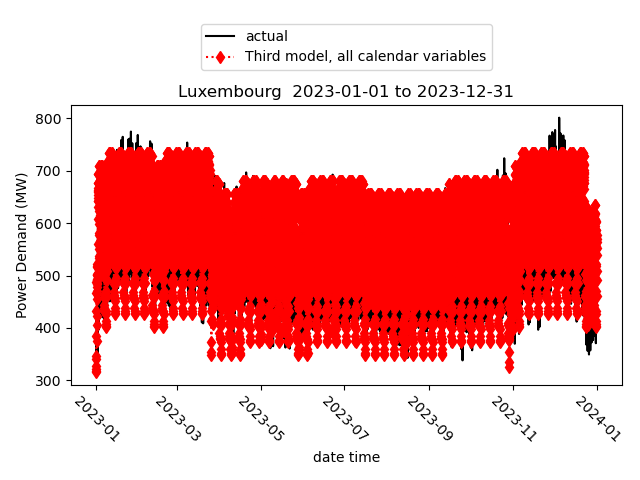

In [18]:
#apply the model to the validation period
P_model3=model3.apply(x_data_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model3, unit='MW', model_name='Third model, all calendar variables', location='Luxembourg')
ev_object.timeseries_plot()

This already looks much better, but there are still substantial differences. And the seasonal pattern is not matched very well. So without even do the full analysis we can see that this forecast is still not as good as the TSO forecast. One of the reasons is of course that weather influences such as the amount of light and the outside temperature are not yet included. So let's include them in the next step.

# Step 6: Add weather data

We use data from the ERA5-Land dataset reanalysis[^1] as weather data, both for training as for evaluation. In a real life demand forecast this would not be possible, because analysis data is 



[^1] Analysis: best estimation of the current state of the weather using all ground measurements, satellite measurements, weather models and datafusion techniques. The Analysis is used at the starting condition for the numerical weather forecast.  Reanalysis: Analysis methods and weather models change and improve over time, which can make historic datasets inconsistent. Reanalysis carries out the analysis on historic data with one method, resulting in a more consistent dataset. 

## download and prepare the weather data

This step can be skipped if you want to work with the Luxembourg example data

In [19]:

#define a ERA% weather object:
ERA5obj=prepdata.ERA5_Weather(startdate, enddate, 'LU', 
                     datafilebasename = f'{filenamebase}_ERA5_weather',
                     loginfile=loginfile)



In [ ]:
#Request and process the weather data
ERA5obj.request_process_save()

## Load the weatherdata, combine with the calendar data, split in a training and validation dataset

In [25]:
#bridgedays, treat the period between christmas and new year also as bridgedays:

print(f'{filenamebase}_ERA5_weather.pkl')
weather_df = pd.read_pickle(f'{filenamebase}_ERA5_weather.pkl')

print(weather_df.index.tz)
      

x_data = prepdata.combines_dfs(hour_as_cat_df, DST_df,typedays_df,holiday_df, bridgeday_df,weather_df )

#split the x_data in training and evaluation data
x_data_train, x_data_2eval  = prepdata.split_df_on_date(splitdate,x_data )  

../data/Luxembourg//LU_2020-01-01_to_2023-12-31_ERA5_weather.pkl
Europe/Luxembourg


Now we can define our new model, train it and validate it

i:  0


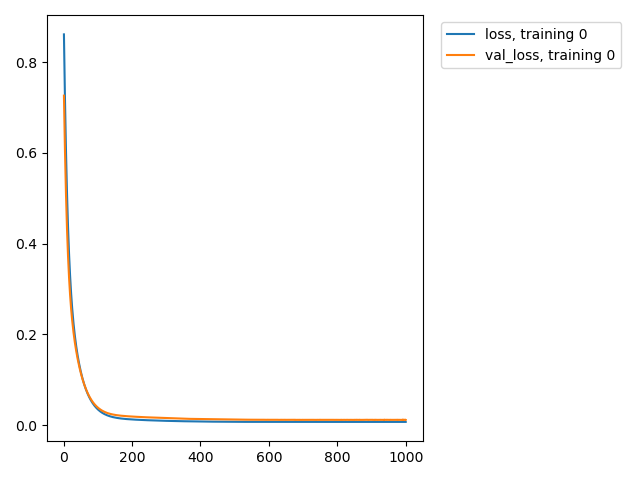

In [26]:
model4 = NN_Model(x_data.columns, hidden_nodes='mean_in_out', hidden_layers=1 )

model4.train_model(x_data_train, actual_train, x_data_2eval,actual2eval,
                   learning_rate=0.0001,verbose=0,epochs=1000, batch_size=100*24)

model4.plot_history()

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


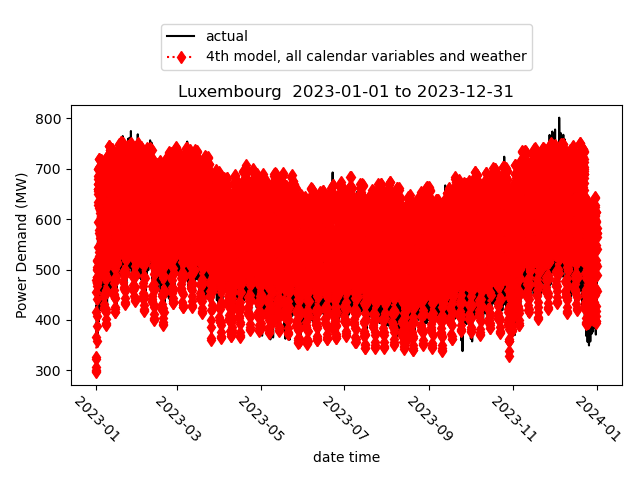

In [29]:
#apply the model to the validation period
P_model4=model4.apply(x_data_2eval)

#create an evaluation object and plot the timeseries
ev_object4= ev.Eval(actual2eval,P_model4, unit='MW', model_name='4th model, all calendar variables and weather', location='Luxembourg')
ev_object4.timeseries_plot()

This looks already much better, but there does seem to be a bias. Let's do a more detailed analysis:

                          value unit  \
total nr data pairs        8760    1   
nr of valid actual points  8760    1   
nr of valid model points   8760    1   
nr of valid data pairs     8760    1   

                                                                 description  
total nr data pairs                               total number of data pairs  
nr of valid actual points  Number of points of the actual (i.e. reference...  
nr of valid model points   Number of data points of the model in the inte...  
nr of valid data pairs       number of valid data pairs in the common period  
                    value unit  \
Mean Actual    536.183933   MW   
Stdv. Actual     98.58936   MW   
Mean Model     571.786316   MW   
Stdv. Model     88.924507   MW   
RMSE            50.474414   MW   
MBE             35.602383   MW   
BoSD            -9.664853   MW   
Disp            34.448909   MW   
MAE             41.610307   MW   
Pearson corr.    0.932318    1   
R2_score         0.737891    1

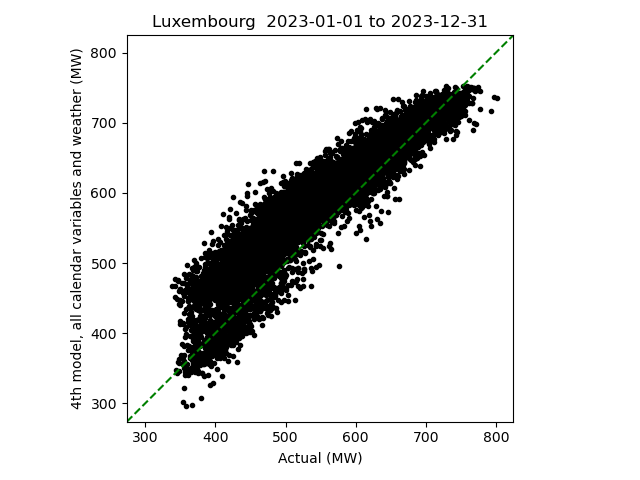

g:\python\DePro\code\evaluate.py:478: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.hist_fig,self.hist_ax = plt.subplots()


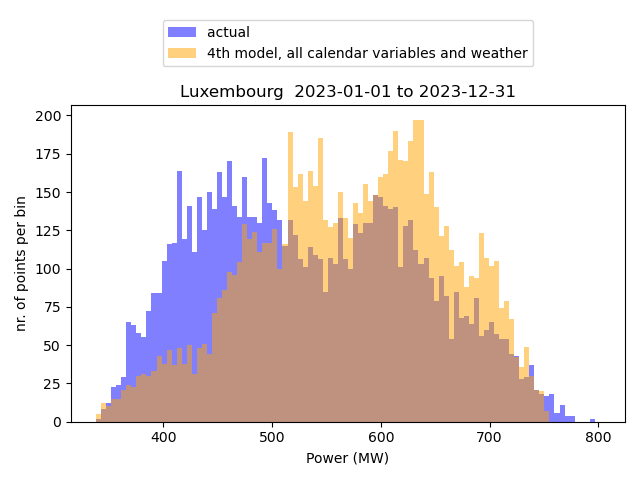

In [31]:


print(ev_object4.data_metrics)

ev_object4.calc_acc_metrics()

print(ev_object4.acc_metrics)

ev_object4.scatter_plot()
ev_object4.hist_compare_plot()


Comparing the results above with the results of the TSO forecast show the neural network forecast is still much poorer. The MBE, the scatterplot and the distribution plot al shows that there is a systematic overestimation by the NN model. Since we are not even using forecasted weather data, this is a bit dissapointing. There are many possible causes:

* choosen NN architecture and NN settings like the choosen loss metric for the NN optimisation.
    * not all the influences have a linear effect, in principle a NN should be able to deal with this, but non-optimal settings or architecture might stand in the way of properly dealing with non-linearities
* long term trends due to changing population, changing economic activity (for example by the pandemic), technological developments (LED's), cultural changes (christmas ornamentation becoming more or less popular)
* other influences not included in the model
* a trend in the bias of the weather data

There are several ways to deal with this:

* compare with a linear regression model. If this has the same problems as the NN the NN architecture and settings are most likely not the problem. This also will give an indication of the magnitude of the influence of each input parameter to the power demand.
* dealing with non-linear relationships by preprocessing the input data (for example taking the logarithm of irradiance, because the human eye/brain percieves logarithmic changes)
* literature research for other influences on the power demand that should be included in the training
* a sliding window for the training period: Before each forecast the NN is reset and trained with data with N years from the past up to the day the forecast is prepared
* additional training: The NN is initially trained with data from a longer period, but before each forecast it is additionally trained with the data of the M last days.
* recursive training: previous forecasts are used as additional training input for the NN, this enables the NN to learn from its mistakes.

Recursive training can be combined with the sliding window and additional training approaches. 